Figure 3A,B
(A, B) Sequence proximal to cryptic splice sites is similar to canonical splice site. Motif information content for 20-mers (A) past the 5’ss and (B) preceding the 3’ss are shown. Image generated with the Bio.motifs package in Python.

In [1]:
import argparse
import glob

import logomaker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from Bio import SeqIO
from Bio import motifs

In [2]:
num=20

def get_motif_5(junx):
    tmp = []
    for x in range(0, junx.shape[0]):
        strand = junx.iloc[x]["strand"]
        chr = str(junx.iloc[x]["chrom"])
        if(strand == "-"):
            pos = junx.iloc[x]["start"]
            input_sequence = genome[chr][(pos - 1):(pos + (num + 0))]
            input_sequence = input_sequence.reverse_complement()
        else:
            pos = junx.iloc[x]["end"]
            input_sequence = genome[chr][(pos - (num+1)):(pos + 0)]
        tmp.append(input_sequence)
    tmp=[i.upper() for i in tmp]
    m = motifs.create(tmp)
    asdf=pd.DataFrame(m.counts)
    asdf=asdf.divide(asdf.sum(axis=1)[0])
    return asdf

def get_motif_3(junx):
    tmp = []
    for x in range(0, junx.shape[0]):
        strand = junx.iloc[x]["strand"]
        chr = str(junx.iloc[x]["chrom"])
        if(strand == "+"):
            pos = junx.iloc[x]["start"]
            input_sequence = genome[chr][(pos - 1):(pos + (num+0))]
        else:
            pos = junx.iloc[x]["end"]
            input_sequence = genome[chr][(pos - (num+1)):(pos + 0)]
            input_sequence = input_sequence.reverse_complement()
        tmp.append(input_sequence)
    tmp=[i.upper() for i in tmp]
    m = motifs.create(tmp)
    asdf=pd.DataFrame(m.counts)
    asdf=asdf.divide(asdf.sum(axis=1)[0])
    return asdf

def read_genome(fasta_fn):
    """Read FASTA file into a dict {chromosome: sequence}."""
    return {
        seq_record.id: seq_record.seq
        for seq_record in SeqIO.parse(fasta_fn, 'fasta')
    }

In [3]:
def table_union(filelist,class_type,n=3 ):
    test = [pd.read_csv(i,sep='\t') for i in filelist]
    test_filt = [
        i.loc[
            (i['class'] == class_type) &
            (i['unique'] >= n)
        ] for i in test
    ]
    
    for df in test_filt:
        df.index = df.chrom.astype('str') + '_' + df.start.astype('str') + '_' + df.end.astype('str')
        
    test_combo = pd.concat(test_filt)

    test_combo=test_combo[
        ~test_combo.index.duplicated(
            keep='first'
        )
    ]
    
    return test_combo

def get_sj(meta_df):
    filelist = []
    for i,row in meta_df.iterrows():
        filepath = '../../data/dtag_experiments/' + \
            row['Target'] + \
            '/sj_out/'+ \
            row['Sample basename']
        filelist.append(glob.glob(filepath+'*')[0])
    return filelist

In [4]:
def plot_logo(asdf,nam,ax=[]):
# create Logo object
    ss_logo = logomaker.Logo(asdf,
                             width=.7,
                             vpad=.05,
                             fade_probabilities=True,
                             stack_order='small_on_top',
                             font_name='Arial Rounded MT Bold',
                             ax=ax
                            )

    # style using Logo methods
    ss_logo.style_spines(
        spines=[
            'left', 
            'right'
        ], 
        visible=False
    )

    # style using Axes methods
    
    ss_logo.ax.set_yticks([0, .5, 1])
    ss_logo.ax.set_ylabel('probability',
                          fontsize=14
                         )
    
    ss_logo.ax.set_title(nam,
                         fontsize=14
                        )

In [5]:
# genome file is path to hg38 ENSEMBL 92 genome fasta
genome = read_genome(
    genome_file
)


In [6]:
meta = pd.read_csv('../../data/dtag_experiments/sum159_all_meta.tsv',sep='\t')

In [7]:
d12_meta_dtag = meta.loc[
    (meta['Clone'] == 'D12') &
    (meta['Target'] == 'DHX15') &
    (meta['Time value'] == 9) & 
    (meta['Dosage value'] == 500)
]

d12_meta_veh = meta.loc[
    (meta['Clone'] == 'D12') &
    (meta['Target'] == 'DHX15') &
    (meta['Time value'] == 9) & 
    (meta['Dosage value'] == 0)
]


In [8]:
d12_dtag_files = get_sj(d12_meta_dtag)
d12_veh_files = get_sj(d12_meta_veh)

In [9]:
nam='matching 5'
match_5_veh = table_union(
    d12_veh_files,
    nam
)

match_5_dtag = table_union(
    d12_dtag_files,
    nam
)

dtag_spec_5=get_motif_5(
    match_5_dtag.loc[
    set(match_5_dtag.index).difference(match_5_veh.index)
])

nam='known intron'
ki_veh_5=table_union(
    d12_veh_files,
    nam
)

ki_5=get_motif_5(
    ki_veh_5
)


/storage/cylin/home/bmho/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


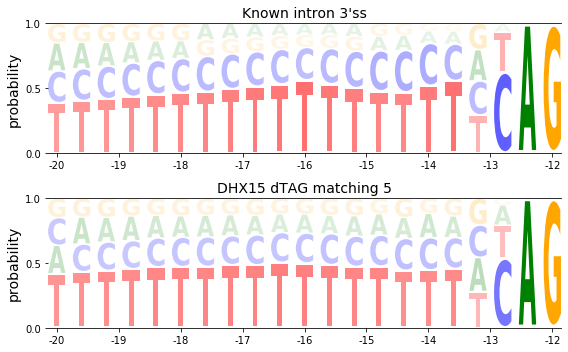

In [10]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,5))

labels = [-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]

plot_logo(ki_5,
          "Known intron 3'ss",
          ax=ax1
         )

plot_logo(dtag_spec_5,
          "DHX15 dTAG matching 5",
          ax=ax2
         )
ax1.set_xticklabels(
    labels=labels)

ax2.set_xticklabels(
    labels=labels)

plt.tight_layout()


In [11]:
nam='matching 3'
match_3_veh=table_union(
    d12_veh_files,
    nam    
)

match_3_dtag=table_union(
    d12_dtag_files,
    nam
)

dtag_spec_3=get_motif_3(
    match_3_dtag.loc[
        set(match_3_dtag.index).difference(match_3_veh.index)
    ]
)

nam='known intron'
ki_veh_3=table_union(
    d12_veh_files,
    nam
)

ki_3=get_motif_3(
    ki_veh_3
)

/storage/cylin/home/bmho/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


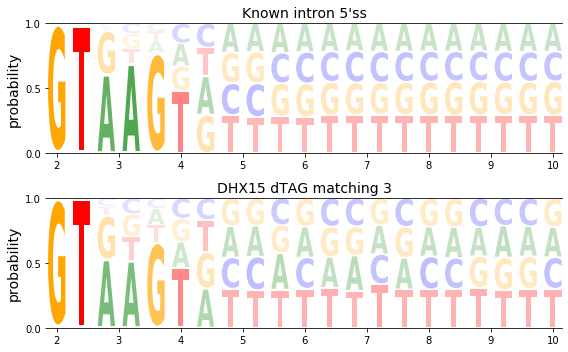

In [12]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,5))

labels = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]

plot_logo(ki_3,
          "Known intron 5'ss",
          ax=ax1
         )

plot_logo(dtag_spec_3,
          "DHX15 dTAG matching 3",
          ax=ax2
         )
ax1.set_xticklabels(
    labels=labels)

ax2.set_xticklabels(
    labels=labels)

plt.tight_layout()


Figure 3C
(C) Sequence surrounding the predicted branch point of cryptic 3’ss is similar to that of canonical splice sites. Motif information content for 7-mers centered on the branchpoint predicted by Branch Point Prediction algorithm is shown. Image generated with the Bio.motifs package in Python.

In [1]:
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from Bio import motifs


In [2]:
matching_5_out = pd.read_csv(
    '/storage/westbrook/projects/dhx15_uj_branchpoint/D5_matching_5_out.tsv',
    sep='\t'
)

ki_matching_5_out = pd.read_csv(
    '/storage/westbrook/projects/dhx15_uj_branchpoint/D5_ki_matching_5_out.tsv',
    sep='\t'
)

matching_5_out = matching_5_out.iloc[::2]

ki_matching_5_out = ki_matching_5_out.iloc[::2]


In [3]:
import logomaker
import matplotlib.pyplot as plt

def plot_logo(tmp,nam,ax):
# create Logo object
    m = motifs.create(tmp)
    asdf=pd.DataFrame(m.counts)
    asdf=asdf.divide(asdf.sum(axis=1)[0])
    
    ss_logo = logomaker.Logo(asdf,
                             width=.7,
                             vpad=.05,
                             fade_probabilities=True,
                             stack_order='small_on_top',
                             font_name='Arial Rounded MT Bold',
                             ax=ax)

    # style using Logo methods
    ss_logo.style_spines(
        spines=[
            'left', 
            'right'
        ], 
        visible=False
    )

    # style using Axes methods
    ss_logo.ax.set_yticks([0, .5, 1])
    ss_logo.ax.set_ylabel('probability',
                          fontsize=14
                         )
    
    ss_logo.ax.set_title(nam,
                         fontsize=14
                        )

findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


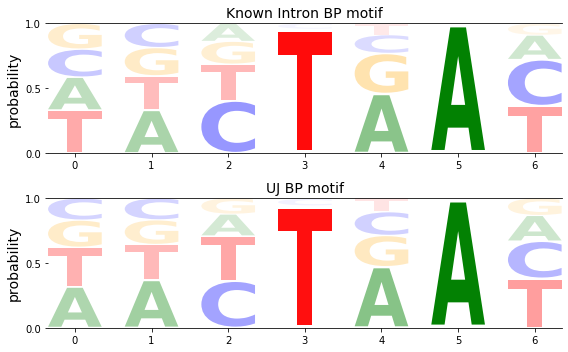

In [4]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(8,5))

plot_logo(ki_matching_5_out.loc[:,'bps'],'Known Intron BP motif',ax=ax1)

plot_logo(matching_5_out.loc[:,'bps'],'UJ BP motif',ax=ax2)

plt.tight_layout()
